# Tech Challenge PosTech - FIAP

Notebook para entrega do Tech Challenge da pós graduação em DATA Analytics na FIAP

- Daniel Lins Toqueiro

## O problema
Você foi recentemente alocado em uma equipe de cientistas de dados de um grande fundo de investimentos brasileiro. Sua missão inicial é desenvolver um modelo preditivo capaz de **prever se o índice IBOVESPA vai fechar em alta ou baixa no dia seguinte,** com base em dados históricos do próprio índice. Esse modelo será usado como insumo para alimentar dashboards internos de tomada de decisão dos analistas quantitativos da empresa.

### Configurações iniciais

#### Importação das Bibliotecas

In [23]:
import torch
import numpy as np
import random
import os
import yfinance as yf
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")

#### Configurações de Reprodutibilidade

In [24]:
# FUNÇÃO PARA GARANTIR REPRODUTIBILIDADE

def definir_semente_reprodutibilidade_aprimorada(semente):
    """
    Define a semente para todas as fontes de aleatoriedade
    para garantir a reprodutibilidade dos resultados.
    """
    random.seed(semente)
    os.environ['PYTHONHASHSEED'] = str(semente)
    np.random.seed(semente)
    torch.manual_seed(semente)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(semente)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Semente de aleatoriedade definida para: {semente}")

# EXECUÇÃO DA FUNÇÃO
SEMENTE_GLOBAL = 42

definir_semente_reprodutibilidade_aprimorada(SEMENTE_GLOBAL)



Semente de aleatoriedade definida para: 42


### Aquisição dos dados

Obs.: Durante as sessões de Grupo de Estudo o professor informou que seria possível fazer a aquisição dos dados utilizando o **Yahoo Finance**, foi escolhida esta solução ao invés de baixar manualmente os dados no site **Investing.com** porque esta alternativa permite adquirir os dados de forma programática.




#### Requisitos:
- Dados no período “diário” ✅
- Intervalo de pelo menos 2 anos de dados. ✅
- Pré-processamento dos dados.✅

#### Adquirindo os dados do Ibovespa

In [25]:

# O ticker para o IBOVESPA no Yahoo Finance é '^BVSP'
ticker = '^BVSP'

# Define o período. Vamos buscar desde 1º de janeiro de 2010 para garantir um intervalo grande, como sugerido. 
data_inicial = '2000-01-01'
data_final = '2025-07-01' 

#Baixando os dados históricos do IBOVESPA
print(f"📥 Baixando dados do IBOVESPA ({ticker}) de {data_inicial} até {data_final}...\n")
dados_ibov = yf.download(ticker, start=data_inicial, end=data_final)
print("✅ Download concluído!")

# Visualização dos primeiros registros do Ibovespa
print("\n📋 Primeiros 5 registros dos dados baixados:")
print(dados_ibov.head())

print(f"\n📋 Temos {len(dados_ibov)} dias de dados.")

[*********************100%***********************]  1 of 1 completed

📥 Baixando dados do IBOVESPA (^BVSP) de 2000-01-01 até 2025-07-01...

✅ Download concluído!

📋 Primeiros 5 registros dos dados baixados:
Price         Close     High      Low     Open Volume
Ticker        ^BVSP    ^BVSP    ^BVSP    ^BVSP  ^BVSP
Date                                                 
2000-01-03  16930.0  17408.0  16719.0  17098.0      0
2000-01-04  15851.0  16908.0  15851.0  16908.0      0
2000-01-05  16245.0  16302.0  15350.0  15871.0      0
2000-01-06  16107.0  16499.0  15977.0  16237.0      0
2000-01-07  16309.0  16449.0  16125.0  16125.0      0

📋 Temos 6313 dias de dados.


#### Ajustando os dados

In [26]:
# retirando o multiindex
dados_ibov.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
print(dados_ibov.head())

              Close     High      Low     Open  Volume
Date                                                  
2000-01-03  16930.0  17408.0  16719.0  17098.0       0
2000-01-04  15851.0  16908.0  15851.0  16908.0       0
2000-01-05  16245.0  16302.0  15350.0  15871.0       0
2000-01-06  16107.0  16499.0  15977.0  16237.0       0
2000-01-07  16309.0  16449.0  16125.0  16125.0       0


###  Exploração dos Dados

#### Valores Nulos 
No conjunto de dados obtidos não há valores nulos então não foi necessário nenhum tratamento neste sentido ✅

In [27]:
print("\n📊 Exploração dos Dados - Valores Nulos:\n")
print("Quantidade de valores nulos por coluna:")
print(dados_ibov.isnull().sum())


📊 Exploração dos Dados - Valores Nulos:

Quantidade de valores nulos por coluna:
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


#### Tipos de Dados


In [28]:
print("\n📊 Exploração dos Dados - Tipos dos dados:\n")
print(dados_ibov.info())


📊 Exploração dos Dados - Tipos dos dados:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6313 entries, 2000-01-03 to 2025-06-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   6313 non-null   float64
 1   High    6313 non-null   float64
 2   Low     6313 non-null   float64
 3   Open    6313 non-null   float64
 4   Volume  6313 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 295.9 KB
None


#### Informações básicas sobre os dados
- Período da Série Histórica 
- Quantidade de Registros 
- Quantidade de valores únicos 

In [29]:
print("\n📊 Informações básicas sobre os dados:\n")
print(f"Período: {dados_ibov['Close'].idxmin().strftime('%Y-%m-%d')} a {dados_ibov['Close'].idxmax().strftime('%Y-%m-%d')}\n")
print(f"Total de registros: {len(dados_ibov)}\n")
print("Valores únicos por coluna:")
print(dados_ibov.nunique())


📊 Informações básicas sobre os dados:

Período: 2002-10-16 a 2025-05-20

Total de registros: 6313

Valores únicos por coluna:
Close     6103
High      6073
Low       6082
Open      6082
Volume    4470
dtype: int64


#### Estatísticas Descritivas


In [30]:
print("📈 Estatísticas descritivas:")
display(dados_ibov[['Close', 'High', 'Low', 'Open', 'Volume']].describe())

📈 Estatísticas descritivas:


,Close,High,Low,Open,Volume
count,6313.000000,6313.000000,6313.000000,6313.000000,6.313000e+03
mean,62199.559322,62782.646761,61590.963250,62182.080627,7.916106e+06
std,35509.320811,35738.750141,35269.046421,35500.741245,2.160434e+07
min,8371.000000,8513.000000,8225.000000,8397.000000,0.000000e+00
25%,36449.000000,36877.000000,35863.000000,36441.000000,0.000000e+00
50%,57348.000000,57929.000000,56836.000000,57350.000000,3.047500e+06
75%,87450.000000,88184.000000,86386.000000,87428.000000,6.924200e+06
max,140110.000000,140382.000000,138966.000000,140109.000000,2.322653e+08


### Gráfico dos dados - Tipo Candlestick

No gráfico podemos observar que o Volume das transações é inconsistente, por conta disso não vamos utilizar esta coluna 

In [31]:
fig = make_subplots(rows=2, cols=1)

fig.update_layout(title='Gráfico de Candlestick do Ibovespa',
                  xaxis_title='Data',
                  yaxis_title='Preço (R$)',
                  height=800,
                  template='plotly_dark')
fig.add_trace(go.Ohlc(x=dados_ibov.index,
                      open=dados_ibov.Open,
                      high=dados_ibov.High,
                      low=dados_ibov.Low,
                      close=dados_ibov.Close,
                      name='Preço'), row=1, col=1)

fig.add_trace(go.Scatter(x=dados_ibov.index, y=dados_ibov.Volume, name='Volume'), row=2, col=1)
fig.update_yaxes(title_text='Volume', row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

#### Dolar
Além dos dados do Ibovespa puxamos também a série histórica do **Dolar** para utilizar em nosso modelo, também vamos puxar os dados utilizando o Yahoo Finance.

In [32]:
# O ticker para o Dolar no Yahoo Finance é 'USDBRL=X'
ticker = "USDBRL=X"

#Usaremos as mesmas datas para o Dólar, de 1º de janeiro de 2010 até 1º de julho de 2025
print(f"📥 Baixando dados do Dolar ({ticker}) de {data_inicial} até {data_final}...\n")
dados_dolar = yf.download(ticker, start=data_inicial, end=data_final)
print("✅ Download concluído!")
# Visualização dos primeiros registros do Dólar
print("\n📋 Primeiros 5 registros dos dados baixados:")
print(dados_dolar.head())

print(f"\n📋 Temos {len(dados_dolar)} dias de dados.")



📥 Baixando dados do Dolar (USDBRL=X) de 2000-01-01 até 2025-07-01...



[*********************100%***********************]  1 of 1 completed

✅ Download concluído!

📋 Primeiros 5 registros dos dados baixados:
Price         Close     High      Low     Open   Volume
Ticker     USDBRL=X USDBRL=X USDBRL=X USDBRL=X USDBRL=X
Date                                                   
2003-12-01    2.923    2.946    2.923    2.946        0
2003-12-02    2.931    2.931    2.923    2.923        0
2003-12-03    2.931    2.936    2.926    2.931        0
2003-12-04    2.943    2.943    2.931    2.931        0
2003-12-05    2.934    2.948    2.934    2.943        0

📋 Temos 5181 dias de dados.


#### Realizando o pré-processamento - Dolar

In [33]:
# Descartando dados desnecessários e renomeando colunas
# Mantendo apenas as colunas relevantes: 'Close', 'High', 'Low', 'Open', 'Volume'
# E renomeando a coluna de data para 'Date' e definindo como índice
dados_dolar = dados_dolar[['Close', "High", "Low", "Open", "Volume"]].dropna().reset_index()
dados_dolar.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
dados_dolar.set_index('Date', inplace=True)

print(f"\n📋 Temos {len(dados_dolar)} dias de dados.")



📋 Temos 5181 dias de dados.


#### Juntando os dados - Ibovespa e Dolar

 

In [34]:
#Juntando os dados do IBOVESPA e do Dólar
dados_ibov = dados_ibov.merge(dados_dolar, on='Date', suffixes=('','_Dolar'))
# Removendo dados nulls que podem ter surgido na junção
dados_ibov = dados_ibov.dropna()
print("\nDados combinados do IBOVESPA e Dólar:")
print(dados_ibov.head())



Dados combinados do IBOVESPA e Dólar:
              Close     High      Low     Open  Volume  Close_Dolar  \
Date                                                                  
2003-12-01  20521.0  20522.0  20184.0  20184.0       0        2.923   
2003-12-02  20458.0  20630.0  20354.0  20523.0       0        2.931   
2003-12-03  20540.0  20586.0  20322.0  20462.0       0        2.931   
2003-12-04  20414.0  20570.0  20323.0  20540.0       0        2.943   
2003-12-05  20880.0  20922.0  20418.0  20418.0       0        2.934   

            High_Dolar  Low_Dolar  Open_Dolar  Volume_Dolar  
Date                                                         
2003-12-01       2.946      2.923       2.946             0  
2003-12-02       2.931      2.923       2.923             0  
2003-12-03       2.936      2.926       2.931             0  
2003-12-04       2.943      2.931       2.931             0  
2003-12-05       2.948      2.934       2.943             0  


### Engenharia de Features

In [35]:
# Criamos um DataFrame para trabalhar com as features
# Vamos manter apenas as colunas de fechamento e fechamento do dólar
# para facilitar a engenharia de atributos
print("\n📋 Criando DataFrame com as colunas relevantes...")
df = dados_ibov[['Close','Close_Dolar']].copy()
print("Dados carregados com sucesso!")

# Criamos a variável alvo (Target)
# O alvo continua sendo a tendência de alta (1) ou baixa (0) do fechamento do dia seguinte
print("\n📋 Criando a variável alvo (Target)...")
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)


# #####################################################################################
#
# OS DADOS FORAM DESLOCADOS |shift(1)| PARA EVITAR VAZAMENTO DE DADOS (data leakage)
#
# #####################################################################################
# Criamos a coluna de variação percentual
# Vamos calcular a variação diária para ser a nossa feature principal
print("\n📋 Calculando a variação percentual diária...")
df['Daily_Change'] = df['Close'].pct_change().shift(1) 
df['Daily_Change_Dolar'] = df['Close_Dolar'].pct_change().shift(1)

# Criamos os atributos de "lag" (valores passados) baseados na variação percentual
# O modelo vai prever a tendência do dia seguinte com base nas variações dos dias anteriores
print("\n📋 Criando atributos de lags...")
janela_lags = [2, 5, 10, 15, 20, 25, 30] # Exemplo de janelas de tempo para os lags
for i in janela_lags:
    df[f'Daily_Change_lag_{i}'] = df['Daily_Change'].shift(i)

# Criamos atributos de Médias Móveis e Médias Exponenciais baseados na variação percentual
# Isso ajuda a suavizar a volatilidade e identificar tendências de variação
print("\n📋 Criando médias móveis e médias exponenciais...")
janela_medias_moveis = [5, 10, 15, 20, 25, 30] # Janelas de tempo para as médias móveis
for i in janela_medias_moveis:
    df[f'MA_{i}_Daily_Change'] = df['Daily_Change'].rolling(window=i).mean()
    df[f'EMA_{i}_Daily_Change'] = df['Daily_Change'].ewm(span=i, adjust=False).mean()


# Limpamos os dados nulos
# A criação de lags e médias móveis resulta em valores nulos (NaN) no início do DataFrame.
# Também o último dia terá NaN na coluna 'Target'.
# Além disso, a coluna 'Close_Dolar' pode ter NaN se o Dólar não tiver cotação naquele dia.
print("\n📋 Limpando dados nulos...")
df.dropna(inplace=True)

# Removendo as colunas auxiliares que não serão features
# As colunas 'Close' e 'Close_Dolar' foram usadas para criar as features, 
# mas o valor absoluto delas pode não ser útil se usarmos os lags e as médias.
# é uma boa prática usar apenas as features derivadas para evitar vazamento de dados (data leakage) e multicolinearidade.
print("\n📋 Removendo colunas auxiliares...")
df.drop(['Close', 'Close_Dolar'], axis=1, inplace=True)

print("\nDataFrame após a Engenharia de Atributos com variação percentual:")
print(df.head())
print("\nÚltimos 5 registros:")
print(df.tail())

print(f"\n✅O DataFrame final agora tem {len(df)} linhas e {len(df.columns)} colunas.")
print("✅As colunas são:", list(df.columns))


📋 Criando DataFrame com as colunas relevantes...
Dados carregados com sucesso!

📋 Criando a variável alvo (Target)...

📋 Calculando a variação percentual diária...

📋 Criando atributos de lags...

📋 Criando médias móveis e médias exponenciais...

📋 Limpando dados nulos...

📋 Removendo colunas auxiliares...

DataFrame após a Engenharia de Atributos com variação percentual:
            Target  Daily_Change  Daily_Change_Dolar  Daily_Change_lag_2  \
Date                                                                       
2004-01-20       0      0.009933            0.003891           -0.018676   
2004-01-21       0      0.012572            0.000000            0.008405   
2004-01-22       1     -0.015921            0.001762            0.009933   
2004-01-23       1     -0.014291           -0.005276            0.012572   
2004-01-26       0      0.021856            0.004243           -0.015921   

            Daily_Change_lag_5  Daily_Change_lag_10  Daily_Change_lag_15  \
Date           

In [36]:
#A variável alvo (Target) indica se o fechamento do dia seguinte será maior (1) ou menor (0) que o fechamento do dia atual.
print("\n📋 Visualizando as primeiras linhas do DataFrame com a variável alvo:")
df[['Daily_Change','Target']].head()


📋 Visualizando as primeiras linhas do DataFrame com a variável alvo:


,Daily_Change,Target
Date,,
2004-01-20,0.009933,0
2004-01-21,0.012572,0
2004-01-22,-0.015921,1
2004-01-23,-0.014291,1
2004-01-26,0.021856,0


### Modelo LTSM

#### Introdução
O LTSM (Long Short-Term Memory ou Memória de Longo e Curto Prazo) é um tipo especial de rede neural projetada para reconhecer padrões em sequências de dados, como, por exemplo, os dados históricos de uma bolsa de valores. 

#### Janelas de Tempo
Para um modelo de série temporal como a LSTM, você precisa criar "janelas deslizantes" de dados. Por exemplo, use os dados dos últimos 30 dias para prever a tendência do dia 31.
A técnica de Janelas de Tempo prepara o modelo para analisar o comportamento dos últimos 30 dias (no nosso caso) para identificar uma tendência.
É uma forma de preparar os dados, transformando uma longa série histórica (como anos de dados do IBOVESPA) em centenas de pequenos "mini-exemplos" de causa e efeito que o modelo pode aprender.

In [37]:
# Agora que temos o DataFrame pronto, vamos criar as janelas de tempo
# Definindo o tamanho da janela de tempo
# Vamos usar uma janela de 30 dias, que é a recomendação para o conjunto de testes
print("\n📋 Definindo o tamanho da janela de tempo...")
tamanho_janela = 30

#Separamos as features e o alvo
print("\n📋 Separando as features e o alvo...")
# As colunas de features são todas as colunas, exceto a coluna 'Target'
# A coluna 'Target' é a nossa variável dependente
features = df.drop('Target', axis=1).values
target = df['Target'].values

#Criando a função para construir as janelas de tempo
def criar_janelas_de_tempo(features, target, tamanho_janela):
    X, y = [], []
    for i in range(len(features) - tamanho_janela):
        # Pega a janela de tempo das features
        janela_features = features[i:(i + tamanho_janela)]
        X.append(janela_features)
        
        # O alvo é o valor 'Target' do dia seguinte à janela
        y.append(target[i + tamanho_janela])
    
    return np.array(X), np.array(y)

#Criando as janelas e os alvos
print(f"\n📋Criando janelas de tempo de {tamanho_janela} dias...")
X, y = criar_janelas_de_tempo(features, target, tamanho_janela)

print("✅ Janelas de tempo criadas com sucesso!")
print(f"Formato de X (janelas de features): {X.shape}") # Exemplo: (1200, 30, 8)
print(f"Formato de y (alvos): {y.shape}") # Exemplo: (1200,)

# Convertendo os dados para tensores do PyTorch
print("\n📋 Convertendo os dados para tensores do PyTorch...")
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long) 

print("\n✅ Dados convertidos para tensores do PyTorch!")
print(f"✅ Formato do tensor X: {X_tensor.shape}")
print(f"✅ Formato do tensor y: {y_tensor.shape}")


📋 Definindo o tamanho da janela de tempo...

📋 Separando as features e o alvo...

📋Criando janelas de tempo de 30 dias...
✅ Janelas de tempo criadas com sucesso!
Formato de X (janelas de features): (4857, 30, 21)
Formato de y (alvos): (4857,)

📋 Convertendo os dados para tensores do PyTorch...

✅ Dados convertidos para tensores do PyTorch!
✅ Formato do tensor X: torch.Size([4857, 30, 21])
✅ Formato do tensor y: torch.Size([4857])


#### Separando os dados em Treino e Teste

In [38]:
# Verificando o número total de registros e o número de features
# Aqui, num_registros_totais é o número total de janelas de tempo criadas
# num_features é o número de features em cada janela de tempo
print("\n📋 Verificando o número total de registros e o número de features...")
num_registros_totais = X.shape[0]
num_features = X.shape[2]
print(f"✅ Número total de registros (janelas): {num_registros_totais}")
print(f"✅ Número de features por janela: {num_features}")

# Separando os dados em conjuntos de treino e teste
# Conforme o requisito do projeto, o conjunto de testes deve conter os últimos 30 dias de dados.
# Como cada janela é de 30 dias, e os alvos correspondem ao dia seguinte,
# 30 dias de teste correspondem a 30 janelas de teste.
print("\n📋 Separando os dados em conjuntos de treino e teste...")
num_dias_teste = 30 
num_janelas_teste = num_dias_teste
# O tamanho do nosso conjunto de treino será o restante
num_janelas_treino = len(X_tensor) - num_janelas_teste

X_treino = X_tensor[:num_janelas_treino]
y_treino = y_tensor[:num_janelas_treino]

X_teste = X_tensor[num_janelas_treino:]
y_teste = y_tensor[num_janelas_treino:]

print("✅ Dados separados com sucesso!")
print(f"Formato do conjunto de treino: {X_treino.shape}, {y_treino.shape}")
print(f"Tamanho do conjunto de treino: {len(X_treino)}")
print(f"\nFormato do conjunto de teste: {X_teste.shape}, {y_teste.shape}")
print(f"Tamanho do conjunto de teste: {len(X_teste)}")



📋 Verificando o número total de registros e o número de features...
✅ Número total de registros (janelas): 4857
✅ Número de features por janela: 21

📋 Separando os dados em conjuntos de treino e teste...
✅ Dados separados com sucesso!
Formato do conjunto de treino: torch.Size([4827, 30, 21]), torch.Size([4827])
Tamanho do conjunto de treino: 4827

Formato do conjunto de teste: torch.Size([30, 30, 21]), torch.Size([30])
Tamanho do conjunto de teste: 30


#### Normalizando os dados

In [39]:
# normalizando os dados


# Calculando a média e o desvio padrão APENAS no conjunto de treino
# Precisamos calcular a média e o desvio padrão para cada feature, em todas as janelas e em todos os dias
# Para isso, vamos "achatar" as dimensões de janela e tempo
# X_treino.view(-1, num_features) transforma o tensor para (total_dias_treino, num_features)
treino_flat = X_treino.view(-1, num_features)
media_treino = treino_flat.mean(dim=0)
desvio_padrao_treino = treino_flat.std(dim=0)

print("\n📋 Calculando a média e o desvio padrão do conjunto de treino...")
print("\nParâmetros de normalização calculados (média e desvio padrão do treino):")
print(f"Média: {media_treino}")
print(f"Desvio Padrão: {desvio_padrao_treino}")


# Aplicando a normalização em ambos os conjuntos
# Normalização (Standard Scaling): (x - media) / desvio_padrao
print("\n📋 Aplicando a normalização em ambos os conjuntos...")
X_treino_normalizado = (X_treino - media_treino) / desvio_padrao_treino
X_teste_normalizado = (X_teste - media_treino) / desvio_padrao_treino # ATENÇÃO: usa os parâmetros do treino!

# Verificando se a normalização foi aplicada corretamente
print("\n📋 Verificando a normalização dos dados...")
print("Primeira janela do conjunto de treino original:")
print(X_treino[0, 0, :]) # Mostra a primeira linha da primeira janela
print("Primeira janela do conjunto de treino normalizado:")
print(X_treino_normalizado[0, 0, :]) # Mostra a primeira linha da primeira janela normalizada

# O y_treino e y_teste não precisam ser normalizados, pois são os rótulos (0 ou 1)
y_treino_final = y_treino
y_teste_final = y_teste

print("\n✅ Dados normalizados com sucesso!")
print("\nFormato final dos dados:")
print(f"X_treino normalizado: {X_treino_normalizado.shape}")
print(f"y_treino: {y_treino_final.shape}")
print(f"X_teste normalizado: {X_teste_normalizado.shape}")
print(f"y_teste: {y_teste_final.shape}")


📋 Calculando a média e o desvio padrão do conjunto de treino...

Parâmetros de normalização calculados (média e desvio padrão do treino):
Média: tensor([0.0005, 0.0002, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005])
Desvio Padrão: tensor([0.0194, 0.0123, 0.0194, 0.0194, 0.0194, 0.0194, 0.0194, 0.0194, 0.0194,
        0.0082, 0.0083, 0.0057, 0.0058, 0.0047, 0.0047, 0.0041, 0.0041, 0.0037,
        0.0037, 0.0034, 0.0034])

📋 Aplicando a normalização em ambos os conjuntos...

📋 Verificando a normalização dos dados...
Primeira janela do conjunto de treino original:
tensor([ 0.0099,  0.0039, -0.0187,  0.0134,  0.0484,  0.0027,  0.0024,  0.0178,
        -0.0031, -0.0070,  0.0008, -0.0005,  0.0012,  0.0052,  0.0022,  0.0061,
         0.0027,  0.0039,  0.0028,  0.0046,  0.0028])
Primeira janela do conjunto de treino normalizado:
tensor([ 0.4846,  0.2987, -0.9913,  0.6622, 

#### Dataset e DataLoader

Criação do Conjunto de Dados e Carregador (Dataset e DataLoader):
- Classe Dataset em PyTorch para carregar seus dados pré-processados e as janelas de tempo.
- DataLoader para carregar os dados em lotes (batches), o que é mais eficiente para o treinamento

In [40]:

# Agora que temos os dados normalizados, vamos criar os objetos Dataset e DataLoader

print("\n📋 Criando os objetos Dataset e DataLoader...")

#Criar uma classe Dataset personalizada
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        # Inicializa o dataset com os tensores de features e targets
        self.X = X
        self.y = y

    def __len__(self):
        # Retorna o número total de amostras (janelas)
        return len(self.X)

    def __getitem__(self, idx):
        # Retorna uma amostra (janela de features) e seu rótulo correspondente
        return self.X[idx], self.y[idx]

# Instanciabdo os objetos Dataset para treino e teste
dataset_treino = TimeSeriesDataset(X_treino_normalizado, y_treino_final)
dataset_teste = TimeSeriesDataset(X_teste_normalizado, y_teste_final)
print("\n✅ Objetos 'Dataset' criados com sucesso!")
print(f"Tamanho do dataset de treino: {len(dataset_treino)} amostras.")
print(f"Tamanho do dataset de teste: {len(dataset_teste)} amostras.")

# Agora vamos criar os objetos DataLoader
# O DataLoader é responsável por carregar os dados em lotes (batches) durante o treinamento
# Isso é mais eficiente do que carregar todos os dados de uma vez, especialmente para grandes conjuntos de dados.

print("\n📋 Criando os objetos DataLoader...")
tamanho_lote = 64 # Este é um hiperparâmetro ajustável
# Um tamanho de lote (batch size) maior pode acelerar o treinamento,
# mas consome mais memória. 64 é um bom valor inicial.

# DataLoader de treino:
# - 'batch_size': número de amostras por lote
# - 'shuffle=True': embaralha os dados em cada época, o que ajuda o modelo
#   a não aprender a ordem dos dados e melhora a generalização.
dataloader_treino = DataLoader(dataset_treino, batch_size=tamanho_lote, shuffle=True)

# DataLoader de teste:
# - 'shuffle=False': não é necessário embaralhar os dados de teste.
dataloader_teste = DataLoader(dataset_teste, batch_size=tamanho_lote, shuffle=False)

print("✅ Objetos 'DataLoader' criados com sucesso!")
print(f"Tamanho do lote (batch size): {tamanho_lote}")



📋 Criando os objetos Dataset e DataLoader...

✅ Objetos 'Dataset' criados com sucesso!
Tamanho do dataset de treino: 4827 amostras.
Tamanho do dataset de teste: 30 amostras.

📋 Criando os objetos DataLoader...
✅ Objetos 'DataLoader' criados com sucesso!
Tamanho do lote (batch size): 64


#### Treinamento do Modelo

In [41]:
# Modelo de Rede Neural para prever a tendência do IBOVESPA
# Definindo o modelo de rede neural
# Usaremos uma LSTM (Long Short-Term Memory) para capturar as dependências temporais dos dados de séries temporais
# A LSTM é uma arquitetura de rede neural recorrente (RNN) que é eficaz para sequências de dados, como séries temporais.

print("\n📋 Definindo o modelo de rede neural...")
class ModeloTendenciaIBOV(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ModeloTendenciaIBOV, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
# Avaliação do modelo
# A função avaliar_modelo recebe o modelo, o DataLoader e o dispositivo (CPU ou GPU)
# Ela calcula a acurácia do modelo no conjunto de dados fornecido
def avaliar_modelo(modelo, dataloader, device):
    modelo.eval()
    with torch.no_grad():
        corretas = 0
        total = 0
        for lote_features, lote_targets in dataloader:
            lote_features = lote_features.to(device)
            lote_targets = lote_targets.to(device)
            saidas = modelo(lote_features)
            _, predicoes = torch.max(saidas.data, 1)
            total += lote_targets.size(0)
            corretas += (predicoes == lote_targets).sum().item()
    acuracia = 100 * corretas / total
    return acuracia



#Loop de treinamento do modelo
# Parâmetros e setup do modelo
print("\n📋 Configurando os parâmetros do modelo...")
SEMENTE_GLOBAL = 42
definir_semente_reprodutibilidade_aprimorada(SEMENTE_GLOBAL)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epocas = 23
taxa_aprendizagem = 0.008
num_features = X.shape[2]
hidden_size = 64
num_layers = 3
output_size = 2
modelo = ModeloTendenciaIBOV(num_features, hidden_size, num_layers, output_size).to(device)
funcao_perda = nn.CrossEntropyLoss()
otimizador = optim.Adam(modelo.parameters(), lr=taxa_aprendizagem)

# Variáveis para salvar o melhor modelo
melhor_acuracia_teste = 0.0
caminho_melhor_modelo = 'melhor_modelo.pth'

print("\n✅ Parâmetros do modelo configurados com sucesso!")
print(f"Dispositivo usado: {device}")
print(f"Número de épocas: {num_epocas}")
print(f"Tamanho do lote (batch size): {tamanho_lote}")
print(f"Número de features: {num_features}")
print(f"Tamanho do hidden layer: {hidden_size}")
print(f"Número de camadas LSTM: {num_layers}")
print(f"Tamanho da saída (output size): {output_size}")

print("\n📋 Iniciando o treinamento com salvamento de checkpoint...")

for epoca in range(num_epocas):
    modelo.train()
    perda_total_epoca = 0
    
    for lote_features, lote_targets in dataloader_treino:
        lote_features, lote_targets = lote_features.to(device), lote_targets.to(device)
        saidas = modelo(lote_features)
        perda = funcao_perda(saidas, lote_targets)
        otimizador.zero_grad()
        perda.backward()
        otimizador.step()
        perda_total_epoca += perda.item()

    # Avaliação ao final de cada época
    acuracia_treino = avaliar_modelo(modelo, dataloader_treino, device)
    acuracia_teste = avaliar_modelo(modelo, dataloader_teste, device)
    perda_media_epoca = perda_total_epoca / len(dataloader_treino)
    
    print(f'Época [{epoca+1}/{num_epocas}], Perda: {perda_media_epoca:.4f}, Acurácia de Treino: {acuracia_treino:.2f}%, Acurácia de Teste: {acuracia_teste:.2f}%')

    # Salvar o modelo se a acurácia de teste for a melhor até agora
    if acuracia_teste > melhor_acuracia_teste:
        melhor_acuracia_teste = acuracia_teste
        # Salvamos um dicionário contendo o estado do modelo e a acurácia
        torch.save(modelo.state_dict(), caminho_melhor_modelo)
        print(f"  --> Modelo salvo com a melhor acurácia de teste: {melhor_acuracia_teste:.2f}%")

print("\n✅ Treinamento concluído!")
print(f"A melhor acurácia de teste alcançada foi: {melhor_acuracia_teste:.2f}%")




📋 Definindo o modelo de rede neural...

📋 Configurando os parâmetros do modelo...
Semente de aleatoriedade definida para: 42

✅ Parâmetros do modelo configurados com sucesso!
Dispositivo usado: cuda
Número de épocas: 23
Tamanho do lote (batch size): 64
Número de features: 21
Tamanho do hidden layer: 64
Número de camadas LSTM: 3
Tamanho da saída (output size): 2

📋 Iniciando o treinamento com salvamento de checkpoint...


Época [1/23], Perda: 0.6956, Acurácia de Treino: 51.73%, Acurácia de Teste: 40.00%
  --> Modelo salvo com a melhor acurácia de teste: 40.00%
Época [2/23], Perda: 0.6932, Acurácia de Treino: 51.73%, Acurácia de Teste: 40.00%
Época [3/23], Perda: 0.6932, Acurácia de Treino: 51.79%, Acurácia de Teste: 40.00%
Época [4/23], Perda: 0.6931, Acurácia de Treino: 51.73%, Acurácia de Teste: 40.00%
Época [5/23], Perda: 0.6928, Acurácia de Treino: 51.73%, Acurácia de Teste: 40.00%
Época [6/23], Perda: 0.6932, Acurácia de Treino: 51.73%, Acurácia de Teste: 40.00%
Época [7/23], Perda: 0.6987, Acurácia de Treino: 51.73%, Acurácia de Teste: 40.00%
Época [8/23], Perda: 0.6931, Acurácia de Treino: 52.52%, Acurácia de Teste: 46.67%
  --> Modelo salvo com a melhor acurácia de teste: 46.67%
Época [9/23], Perda: 0.6923, Acurácia de Treino: 55.27%, Acurácia de Teste: 60.00%
  --> Modelo salvo com a melhor acurácia de teste: 60.00%
Época [10/23], Perda: 0.6896, Acurácia de Treino: 54.07%, Acurácia de Teste: 56

#### Avaliação do modelo


✅ Carregando o melhor modelo salvo de 'melhor_modelo.pth'...

Matriz de Confusão:

Verdadeiros positivos (TP): 12
Falsos positivos (FP): 7
Verdadeiros negativos (TN): 11
Falsos negativos (FN): 0


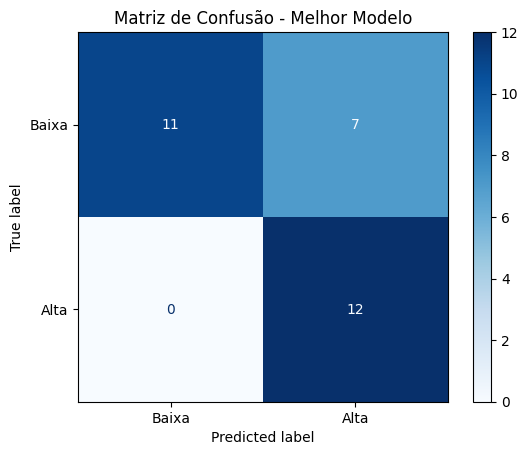

Acurácia do teste calculada com sklearn: 76.67%


In [42]:
# Avaliação final do melhor modelo
# ##########################################################################
# CARREGAR O MELHOR MODELO SALVO
# ##########################################################################

print(f"\n✅ Carregando o melhor modelo salvo de '{caminho_melhor_modelo}'...")
melhor_modelo = ModeloTendenciaIBOV(num_features, hidden_size, num_layers, output_size).to(device)
melhor_modelo.load_state_dict(torch.load(caminho_melhor_modelo))


# Gerando as previsões para o conjunto de teste
y_pred = []
melhor_modelo.eval()
for lote_features, _ in dataloader_teste:
    lote_features = lote_features.to(device)
    with torch.no_grad():
        saidas = melhor_modelo(lote_features)
    _, predicoes = torch.max(saidas.data, 1)
    y_pred.extend(predicoes.cpu().numpy())

# Gerando a matriz de confusão
cm = confusion_matrix(y_teste_final, y_pred)
print("\nMatriz de Confusão:")
print("\nVerdadeiros positivos (TP):", cm[1, 1])
print("Falsos positivos (FP):", cm[0, 1])
print("Verdadeiros negativos (TN):", cm[0, 0])
print("Falsos negativos (FN):", cm[1, 0])
# Plotando a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Baixa', 'Alta'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Melhor Modelo')
plt.show()

# Avaliação final com sklearn
test_accuracy = accuracy_score(y_teste_final, y_pred)
print(f"Acurácia do teste calculada com sklearn: {test_accuracy*100:.2f}%")

In [43]:
# Verifica se atingiu a meta
if test_accuracy >= 0.75:
    print("🎯 META ATINGIDA! Acurácia >= 75%")
else:
    print(f"⚠️  Meta não atingida. Faltam {(0.75 - test_accuracy)*100:.2f}% para 75%")

# Avaliação final do melhor modelo (carregado)
acuracia_final_melhor_modelo = avaliar_modelo(melhor_modelo, dataloader_teste, device)
print(f"Acurácia final do melhor modelo (carregado) no conjunto de teste: {acuracia_final_melhor_modelo:.2f}%")

🎯 META ATINGIDA! Acurácia >= 75%
Acurácia final do melhor modelo (carregado) no conjunto de teste: 76.67%
